Test the mapmaking.

Change forward modelling code to make the timestream zenith drift thing then plot a LST vs sky temperature graph. Delete the identity pointing matrix thing there and move it here. Meanwhile, in this code, test different observation strategy reconstructions including identity pointing, zenith pointing, multiple zenith pointing antennas, multiple beam functions, etc.

In [3]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.coordinates as CO
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM

RS = SH.RealSphericalHarmonics()

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


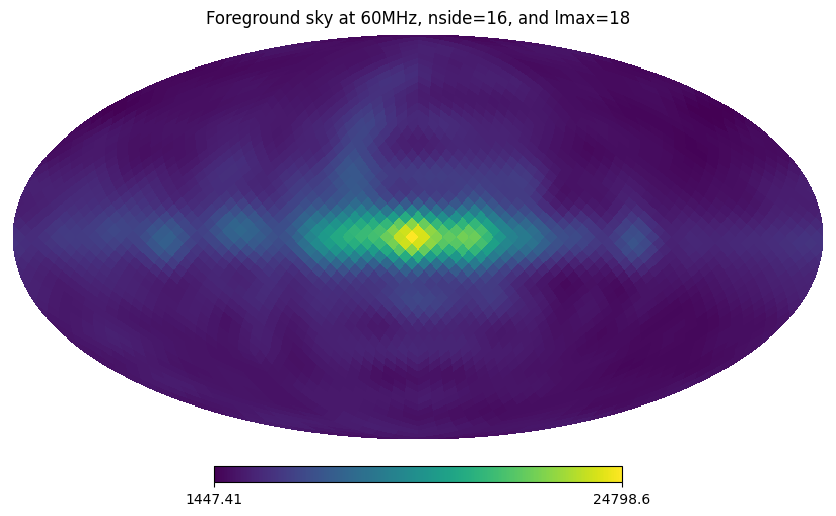

In [4]:
# Create a sky map of the foregrounds.
lmax = 18
nside = 2**4
npix = hp.nside2npix(nside)
fg_alm, fg_map = SM.foreground_gdsm_alm(nu=60, lmax=lmax, nside=nside, map=True)
hp.mollview(fg_map, title=f"Foreground sky at 60MHz, nside={nside}, and lmax={lmax}")

3072 190


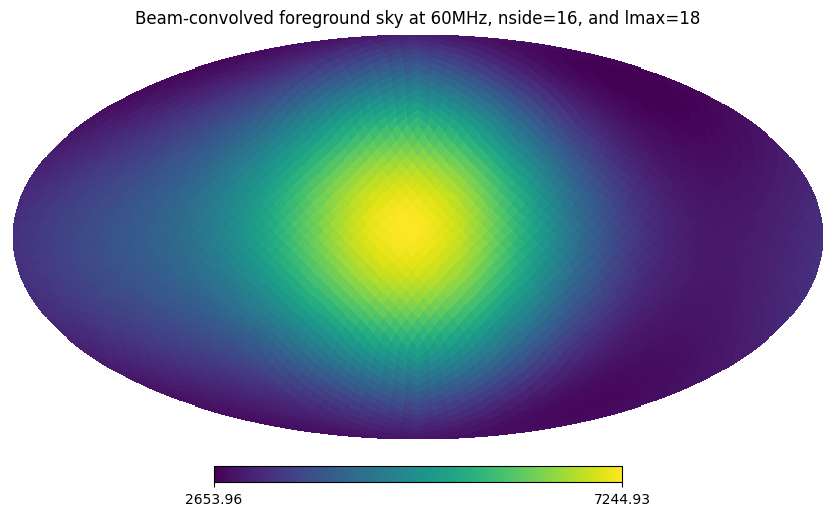

In [5]:
# Convolve the map with a cos^2 beam.
cb = lambda theta: BF.beam_cos(theta, theta0=1)
beam_mat = BF.calc_beam_matrix(nside=nside, lmax=lmax, beam_use=cb)
ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)
fg_convolved_map = ylm_mat @ beam_mat @ fg_alm
hp.mollview(fg_convolved_map, 
            title=f"Beam-convolved foreground sky at 60MHz, nside={nside}, and lmax={lmax}")

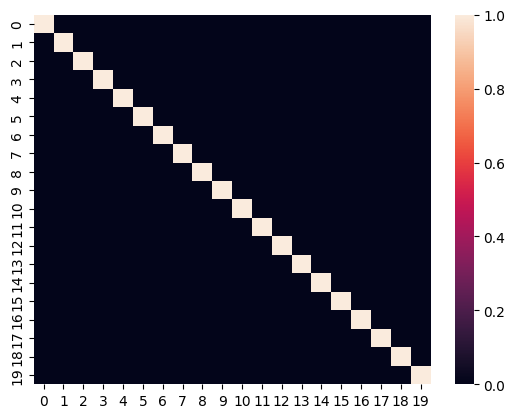

In [6]:
# Build pointing matrix for the ideal scenario - one pointing per pixel in the
# sky. This means the pointing matrix is the (npix x npix) identity matrix.
pointing_mat_ideal = np.diag(np.ones(shape=npix))
sns.heatmap(pointing_mat_ideal[:20,:20])
plt.show()

In [7]:
# Complete the observation by applying the pointing matrix.
data_ideal = pointing_mat_ideal @ fg_convolved_map
data_ideal_noisy, ideal_noise_covar = SM.add_noise(data_ideal, dnu=1, Ntau=npix, t_int=1e4*npix)

## Perfect observation strategy and all l modes modelled
### Cosine-squared beam used

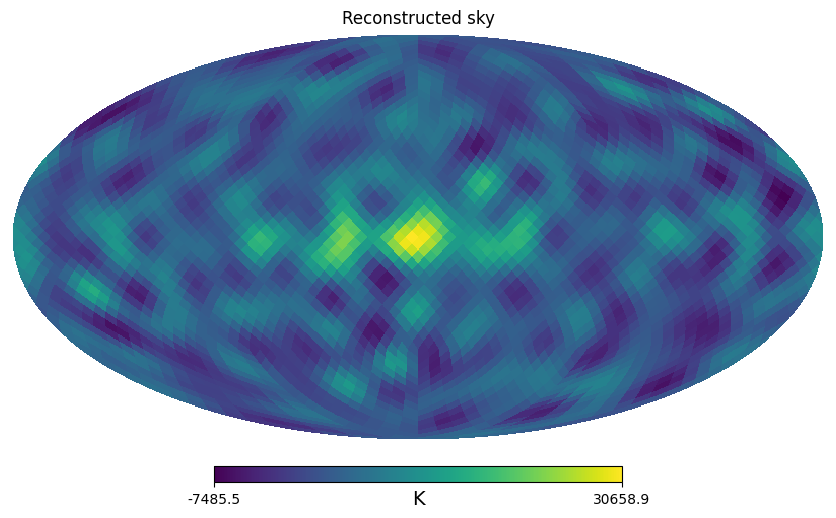

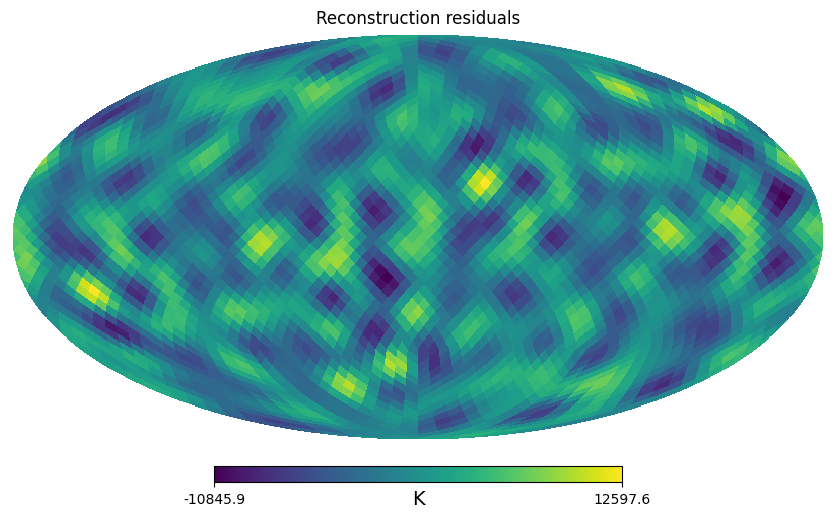

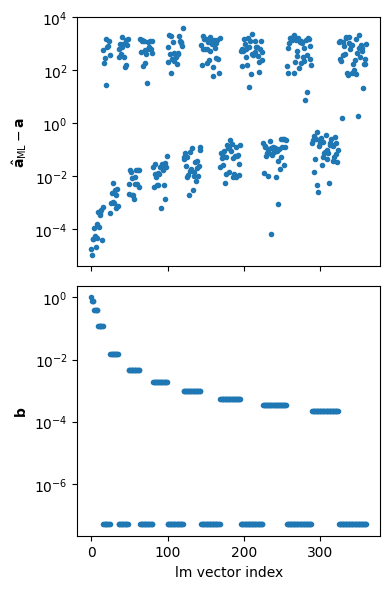

'Not sure what this last figure indicates - interesting to talk about.'

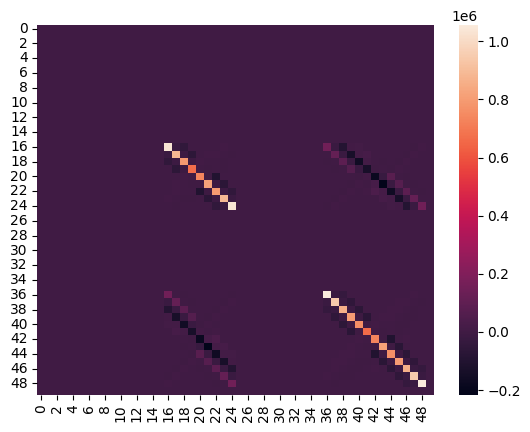

In [8]:
# Reconstruct the original map.
ideal_mat_W, ideal_estimate_cov = MM.calc_ml_estimator_matrix(
    mat_A = pointing_mat_ideal @ ylm_mat @ beam_mat,
    mat_N = ideal_noise_covar,
    cov = True
)
fg_alm_ideal_estimate = ideal_mat_W @ data_ideal_noisy

hp.mollview(ylm_mat @ fg_alm_ideal_estimate, title="Reconstructed sky", unit='K')
plt.show()
hp.mollview(ylm_mat @ (fg_alm_ideal_estimate - fg_alm), 
            title="Reconstruction residuals", unit='K')
plt.show()

beam_blm = np.diag(beam_mat)
f, a = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
a[0].semilogy(range(len((fg_alm_ideal_estimate - fg_alm))), abs(fg_alm_ideal_estimate - fg_alm), '.')
a[1].semilogy(abs(beam_blm), '.')
a[1].set_xlabel("lm vector index")
a[0].set_ylabel(r"$\mathbf{\hat{a}}_\mathrm{ML} - \mathbf{a}$")
a[1].set_ylabel(r"$\mathbf{b}$")
f.tight_layout()
plt.show()

sns.heatmap(ideal_estimate_cov[:50,:50])
"Not sure what this last figure indicates - interesting to talk about."

In [9]:
# Which of the (l,m) are not being estimated well?
for i, val in enumerate(abs(fg_alm_ideal_estimate - fg_alm)):
    if val > 1:
        print(f"(l, m) = {RS.get_lm(i)}")

(l, m) = (4, -4)
(l, m) = (4, -3)
(l, m) = (4, -2)
(l, m) = (4, -1)
(l, m) = (4, 0)
(l, m) = (4, 1)
(l, m) = (4, 2)
(l, m) = (4, 3)
(l, m) = (4, 4)
(l, m) = (6, -6)
(l, m) = (6, -5)
(l, m) = (6, -4)
(l, m) = (6, -3)
(l, m) = (6, -2)
(l, m) = (6, -1)
(l, m) = (6, 0)
(l, m) = (6, 1)
(l, m) = (6, 2)
(l, m) = (6, 3)
(l, m) = (6, 4)
(l, m) = (6, 5)
(l, m) = (6, 6)
(l, m) = (8, -8)
(l, m) = (8, -7)
(l, m) = (8, -6)
(l, m) = (8, -5)
(l, m) = (8, -4)
(l, m) = (8, -3)
(l, m) = (8, -2)
(l, m) = (8, -1)
(l, m) = (8, 0)
(l, m) = (8, 1)
(l, m) = (8, 2)
(l, m) = (8, 3)
(l, m) = (8, 4)
(l, m) = (8, 5)
(l, m) = (8, 6)
(l, m) = (8, 7)
(l, m) = (8, 8)
(l, m) = (10, -10)
(l, m) = (10, -9)
(l, m) = (10, -8)
(l, m) = (10, -7)
(l, m) = (10, -6)
(l, m) = (10, -5)
(l, m) = (10, -4)
(l, m) = (10, -3)
(l, m) = (10, -2)
(l, m) = (10, -1)
(l, m) = (10, 0)
(l, m) = (10, 1)
(l, m) = (10, 2)
(l, m) = (10, 3)
(l, m) = (10, 4)
(l, m) = (10, 5)
(l, m) = (10, 6)
(l, m) = (10, 7)
(l, m) = (10, 8)
(l, m) = (10, 9)
(l, m) 

Looks like all of the l=even for l>=4 are not being estimated well, as the cosine squared beam does not feature these modes.

Before we do the sensible thing of using a better beamfunction, let's remove the badly modelled modes from the fg reconstruction and see what that looks like.

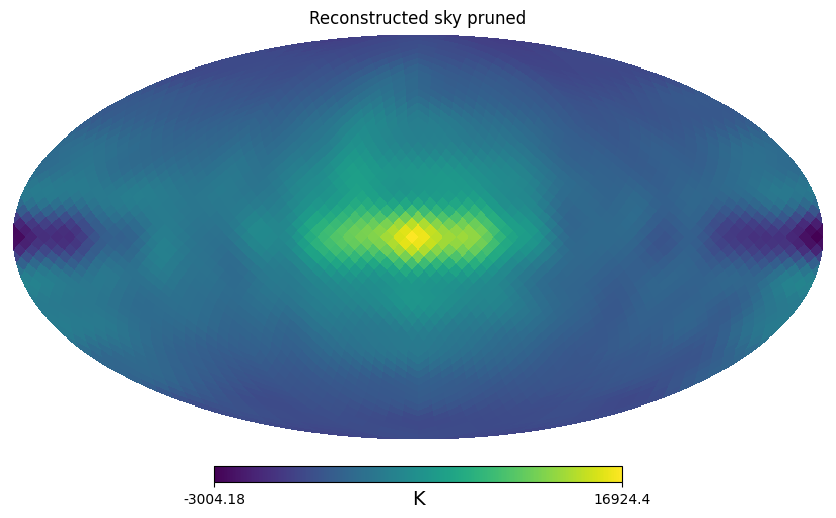

In [10]:
fg_alm_ideal_estimate_pruned = np.array(fg_alm_ideal_estimate)
for i, val in enumerate(abs(fg_alm_ideal_estimate - fg_alm)):
    if val > 1:
        fg_alm_ideal_estimate_pruned[i] = 0

hp.mollview(ylm_mat @ fg_alm_ideal_estimate_pruned, title="Reconstructed sky pruned", unit='K')
plt.show()

This definitely does look better.



## Perfect observation strategy
### Investigate other beams

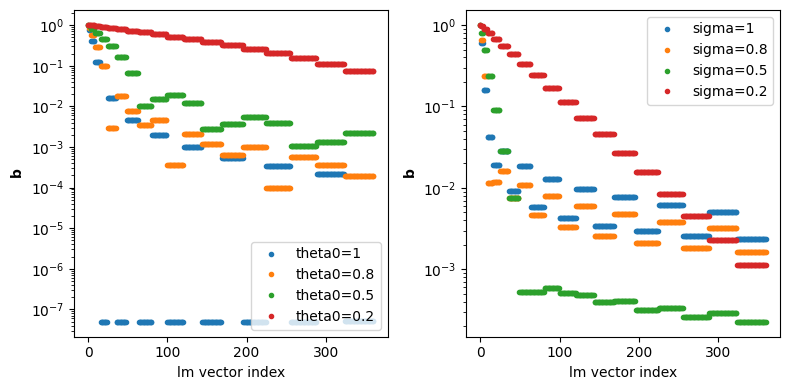

In [11]:
# Generate a range of cosine-squared beams.
theta0_list = [1, 0.8, 0.5, 0.2]
cos_squared_funcs = []
for theta0 in theta0_list:  #quirk of how lambda and loops interact
    cos_squared_funcs.append(lambda theta, this_theta0=theta0: BF.beam_cos(theta, theta0=this_theta0))

beam_cos_matrices = [BF.calc_beam_matrix(nside=nside, lmax=lmax, beam_use=func) for func in cos_squared_funcs]
beam_cos_blms = [np.diag(mat) for mat in beam_cos_matrices]


# Generate a corresponding range of gaussian beams.
sigma_list = [1, 0.8, 0.5, 0.2]
gauss_funcs = []
for sigma in sigma_list:  #quirk of how lambda and loops interact
    gauss_funcs.append(lambda theta, this_theta0=sigma: BF.beam_gauss(theta, theta0=this_theta0))

beam_gauss_matrices = [BF.calc_beam_matrix(nside=nside, lmax=lmax, beam_use=func) for func in gauss_funcs]
beam_gauss_blms = [np.diag(mat) for mat in beam_gauss_matrices]

f, a = plt.subplots(1, 2, figsize=(8, 4))
for theta0, beam_blm in zip(theta0_list, beam_cos_blms):
    a[0].semilogy(abs(beam_blm), '.', label=f"theta0={theta0}")
a[0].legend(loc="lower right")
a[0].set_ylabel(r"$\mathbf{b}$")
a[0].set_xlabel("lm vector index")
for sigma, beam_blm in zip(sigma_list, beam_gauss_blms):
    a[1].semilogy(abs(beam_blm), '.', label=f"sigma={sigma}")
a[1].legend(loc="upper right")
a[1].set_ylabel(r"$\mathbf{b}$")
a[1].set_xlabel("lm vector index")
f.tight_layout()

### Try a narrower beam

In [15]:
ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)

# Calculate total observation matrix.
mat_A_narrowbeam = FM.calc_observation_matrix_all_pix(
    nside=nside, 
    lmax=lmax, 
    Ntau=npix, 
    Nt=npix,
    beam_use=lambda theta: BF.beam_cos(theta, theta0=.8)
)
# Generate data.
data_narrowbeam = mat_A_narrowbeam @ fg_alm
noisy_data_narrowbeam, noise_cov_narrowbeam = SM.add_noise(data_narrowbeam, dnu=1, Ntau=npix, t_int=1e4*npix)

# Invert to make map.
mat_W_narrowbeam, model_covar_narrowbeam = MM.calc_ml_estimator_matrix(
    mat_A=mat_A_narrowbeam, 
    mat_N=noise_cov_narrowbeam, 
    cov=True
)
model_estimate_narrowbeam = mat_W_narrowbeam @ noisy_data_narrowbeam


3072 190
3072 190


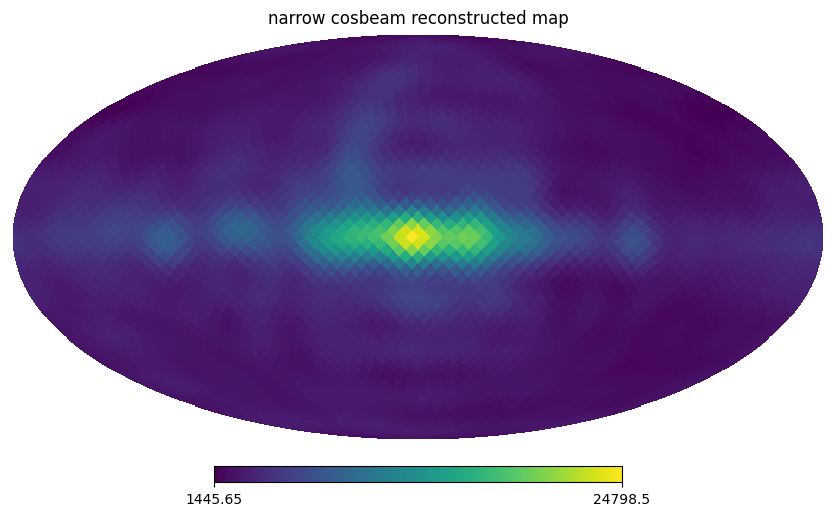

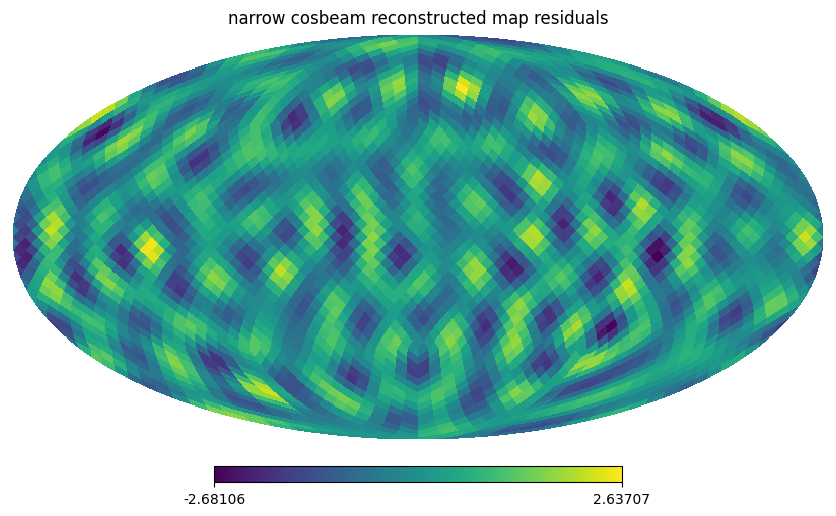

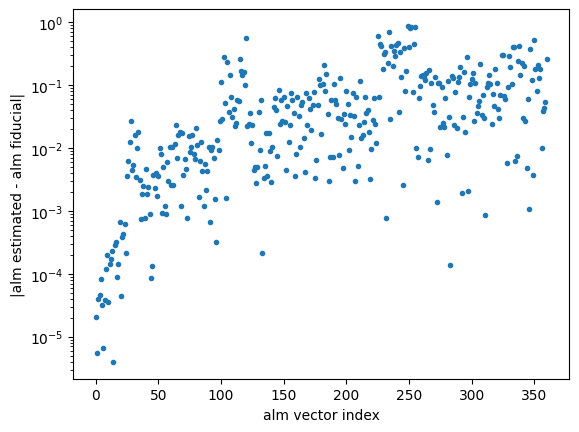

In [19]:
# Plot
hp.mollview(ylm_mat@model_estimate_narrowbeam, title="narrow cosbeam reconstructed map")
plt.show()

hp.mollview(ylm_mat@(model_estimate_narrowbeam - fg_alm), title="narrow cosbeam reconstructed map residuals")
plt.show()

plt.semilogy(range(len((model_estimate_narrowbeam - fg_alm))), abs(model_estimate_narrowbeam - fg_alm), '.')
plt.xlabel("alm vector index")
plt.ylabel("|alm estimated - alm fiducial|")
plt.show()